##Customer Churn##

Credits: Forked from [growth-workshop](https://github.com/aprial/growth-workshop) by [aprial](https://github.com/aprial), as featured on the [yhat blog](http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html)


"Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive).

Understanding what keeps customers engaged, therefore, is incredibly valuable, as it is a logical foundation from which to develop retention strategies and roll out operational practices aimed to keep customers from walking out the door. Consequently, there's growing interest among companies to develop better churn-detection techniques, leading many to look to data mining and machine learning for new and creative approaches.

Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. But modeling churn has wide reaching applications in many domains. For example, casinos have used predictive models to predict ideal room conditions for keeping patrons at the blackjack table and when to reward unlucky gamblers with front row seats to Celine Dion. Similarly, airlines may offer first class upgrades to complaining customers. The list goes on.

Wait, don't go!

So what are some of ops strategies that companies employ to prevent churn? Well, reducing churn, it turns out, often requires non-trivial resources. Specialized retention teams are common in many industries and exist expressly to call down lists of at-risk customers to plead for their continued business.

![](http://blog.yhathq.com/static/img/netflix.png)

Organizing and running such teams is tough. From an ops perspective, cross-geographic teams must be well organized and trained to respond to a huge spectrum of customer complaints. Customers must be accurately targeted based on churn-risk, and retention treatments must be well-conceived and correspond reasonably to match expected customer value to ensure the economics make sense. Spending $1,000 on someone who wasn't about to leave can get expensive pretty quickly.

Within this frame of mind, efficiently dealing with turnover is an exercise of distinguishing who is likely to churn from who is not using the data at our disposal. The remainder of this post will explore a simple case study to show how Python and its scientific libraries can be used to predict churn and how you might deploy such a solution within operations to guide a retention team.

##The Dataset##

The data set we'll be using is a longstanding telecom customer data set.

The data is straightforward. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 


In [2]:
churn_df = pd.read_csv('../data/churn.csv')
col_names = churn_df.columns.tolist()

print ("Column names:")
print (col_names)

to_show = col_names[:6] + col_names[-6:]

print ("\nSample data:")
churn_df[to_show].head(6)
      

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


We'll be keeping the statistical model pretty simple for this example so the feature space is almost unchanged from what you see above. The following code simply drops irrelevant columns and converts strings to boolean values (since models don't handle "yes" and "no" very well). The rest of the numeric columns are left untouched.

In [3]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)


In [4]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [5]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [6]:
# Pull out features for future use
features = churn_feat_space.columns
print (features)

Index([u'Account Length', u'Int'l Plan', u'VMail Plan', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'], dtype='object')


In [7]:
X = churn_feat_space.as_matrix().astype(np.float)

# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))
      

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. `StandardScaler` fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

Great, I now have a feature space `X` and a set of target values `y`. On to the predictions!

##How good is your model?##

Express, test, cycle. A machine learning pipeline should be anything but static. There are always new features to design, new data to use, new classifiers to consider each with unique parameters to tune. And for every change it's critical to be able to ask, "Is the new version better than the last?" So how do I do that?

As a good start, cross validation will be used throught this example. Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. This is accomplished by systematically hiding different subsets of the data while training a set of models. After training, each model predicts on the subset that had been hidden to it, emulating multiple train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

Here's what that looks like using `scikit-learn` libraries.

In [8]:
from sklearn.model_selection import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Let's compare three fairly unique algorithms support vector machines, random forest, and k-nearest-neighbors. Nothing fancy here, just passing each to cross validation and determining how often the classifier predicted the correct class.

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print ("Logistic Regression:")
print ("%.3f" % accuracy(y, run_cv(X,y,LR)))
print ("Gradient Boosting Classifier")
print ("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Logistic Regression:
0.862
Gradient Boosting Classifier
0.950
Support vector machines:
0.912
Random forest:
0.935
K-nearest-neighbors:
0.893



Random forest won, right?

##Precision and recall##

Measurements aren't golden formulas which always spit out high numbers for good models and low numbers for bad ones. Inherently they convey something sentiment about a model's performance, and it's the job of the human designer to determine each number's validity. The problem with accuracy is that outcomes aren't necessarily equal. If my classifier predicted a customer would churn and they didn't, that's not the best but it's forgivable. However, if my classifier predicted a customer would return, I didn't act, and then they churned... that's really bad.

We'll be using another built in `scikit-learn` function to construction a confusion matrix. A confusion matrix is a way of visualizing predictions made by a classifier and is just a table showing the distribution of predictions for a specific class. The x-axis indicates the true class of each observation (if a customer churned or not) while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).

## Confusion matrix and confusion tables: 
The columns represent the actual class and the rows represent the predicted class. Lets evaluate performance: 

|      | condition True | condition false|
|------|----------------|---------------|
|prediction true|True Positive|False positive|
|Prediction False|False Negative|True Negative|

Sensitivity, Recall or True Positive Rate quantify the models ability to predict our positive classes. 

$$TPR = \frac{ TP}{TP + FN}$$ 

Specificity or True Negative Rate quantify the models ability to predict our Negative classes. 

$$TNR = \frac{ TN}{FP + TN}$$ 

### Example:

|      | Spam | Ham|
|------|----------------|---------------|
|prediction Spam|100|50|
|Prediction Ham|75|900|

$$TPR = \frac{100}{100 + 75} = 57.14 \%   Sensitive $$

$$TNR = \frac{ 900}{50 + 900} = 94.73 \% Specific $$



[[2821   29]
 [ 244  239]]


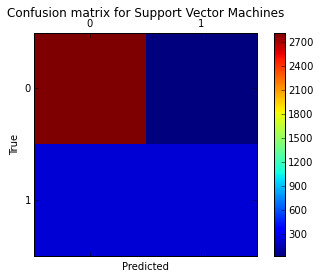

[[2814   36]
 [ 147  336]]


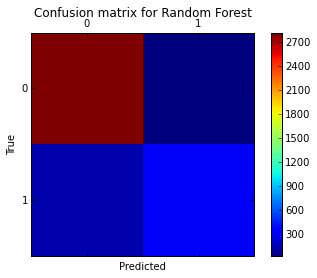

[[2813   37]
 [ 317  166]]


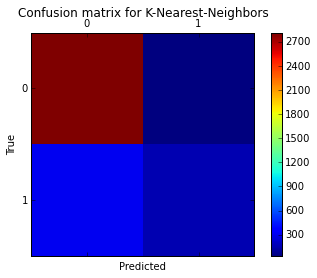

[[2820   30]
 [ 124  359]]


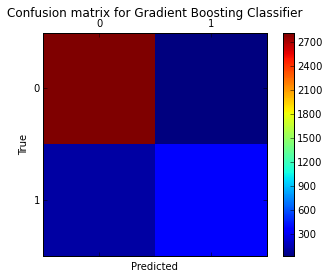

[[2769   81]
 [ 381  102]]


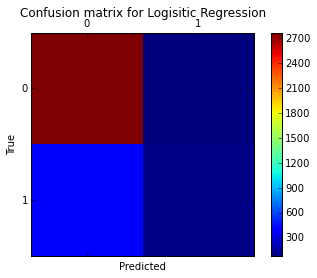

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

An important question to ask might be, When an individual churns, how often does my classifier predict that correctly? This measurement is called "recall" and a quick look at these diagrams can demonstrate that random forest is clearly best for this criteria. Out of all the churn cases (outcome "1") random forest correctly retrieved 330 out of 482. This translates to a churn "recall" of about 68% (330/482≈2/3), far better than support vector machines (≈50%) or k-nearest-neighbors (≈35%).

Another question of importance is "precision" or, When a classifier predicts an individual will churn, how often does that individual actually churn? The differences in sematic are small from the previous question, but it makes quite a different. Random forest again out preforms the other two at about 93% precision (330 out of 356) with support vector machines a little behind at about 87% (235 out of 269). K-nearest-neighbors lags at about 80%.

While, just like accuracy, precision and recall still rank random forest above SVC and KNN, this won't always be true. When different measurements do return a different pecking order, understanding the values and tradeoffs of each rating should effect how you proceed.

## ROC Plots & AUC

Another important metric to consider is ROC plots. We'll cover the majority of these concepts in lecture, but if you're itching for more, one of the best resources out there is this [academic paper](https://cours.etsmtl.ca/sys828/REFS/A1/Fawcett_PRL2006.pdf). 

Simply put, the area under the curve (AUC) of a receiver operating characteristic (ROC) curve is a way to reduce ROC performance to a single value representing expected performance.
To explain with a little more detail, a ROC curve plots the true positives (sensitivity) vs. false positives (1 − specificity), for a binary classifier system as its discrimination threshold is varied. Since a random method describes a horizontal curve through the unit interval, it has an AUC of .5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance. 

Support vector machines:


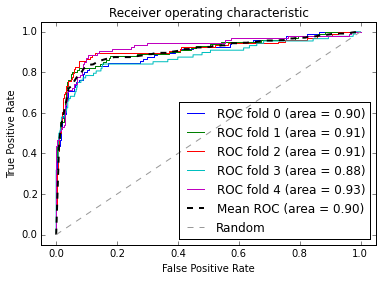

Random forests:


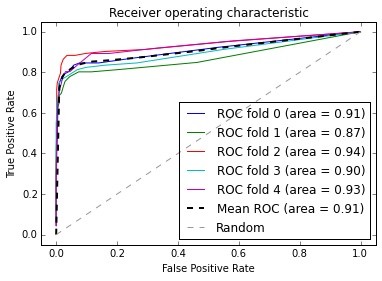

K-nearest-neighbors:


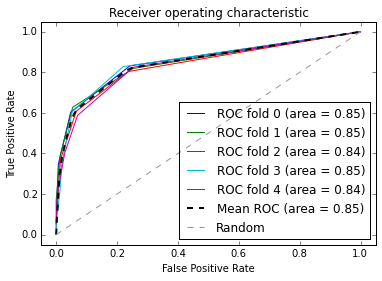

Gradient Boosting Classifier:


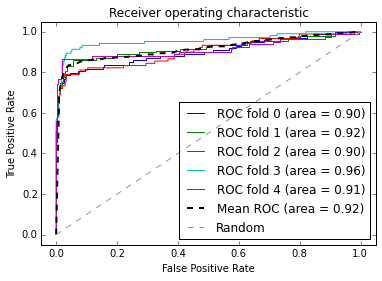

In [11]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print ("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print ("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print ("K-nearest-neighbors:")
plot_roc(X,y,KNN)

print ("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

## Feature Importance

Now that we understand the accuracy of each individual model for our particular dataset, let's dive a little deeper to get a better understanding of what features or behaviours are causing our customers to churn. In the next section, we will be using a `RandomForestClassifer` to build an ensemble of decision trees to predict whether a customer will churn or not churn. One of the first steps in building a decision tree to calculating the _information gain_ associated with splitting on a particular feature. (More on this later.)

Let's look at the Top 10 features in our dataset that contribute to customer churn:

Feature ranking:
1. Account Length (0.188157)
2. Int'l Plan (0.102871)
3. VMail Plan (0.096911)
4. VMail Message (0.071246)
5. Day Mins (0.062060)
6. Day Calls (0.032456)
7. Day Charge (0.030478)
8. Eve Mins (0.026043)
9. Eve Calls (0.025411)
10. Eve Charge (0.021707)


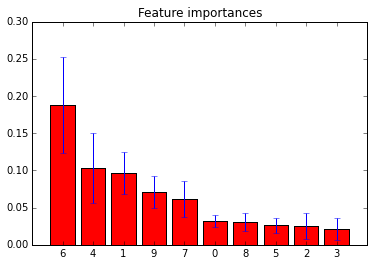

In [12]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

## Thinking in Probabilities

Decision making often favors probability over simple classifications. There's plainly more information in statements like "there's a 20% chance of rain tomorrow" and "about 55% of test takers pass the California bar exam" than just saying "it shouldn't rain tomorrow" or "you'll probably pass." Probability predictions for churn also allow us to gauge a customers expected value, and their expected loss. Who do you want to reach out to first, the client with a 80% churn risk who pays 20,000 annually, or the client who's worth 100,000 a year with a 40% risk? How much should you spend on each client?

While I'm moving a bit away from my expertise, being able to ask that question requires producing predictions a little differently. However, `scikit-learn` makes moving to probabilities easy; my three models have `predict_proba()` built right into their class objects. This is the same cross validation code with only a few lines changed.

In [13]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

## How good is good?

Determining how good a predictor which gives probabilities rather than classes is a bit more difficult. If I predict there's a 20% likelihood of rain tomorrow I don't get to live out all the possible outcomes of the universe. It either rains or it doesn't.

What helps is that the predictors aren't making one prediction, they're making 3000+. So for every time I predict an event to occur 20% of the time I can see how often those events actually happen. Here's we'll use `pandas` to help me compare the predictions made by random forest against the actual outcomes.

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1796
0.1     681
0.2     258
0.3     112
0.8      94
0.9      89
0.7      79
0.4      74
0.5      53
0.6      50
1.0      47
dtype: int64

In [15]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1796,0.027840
1,0.1,681,0.020558
2,0.2,258,0.081395
3,0.3,112,0.089286
4,0.4,74,0.270270
5,0.5,53,0.622642
6,0.6,50,0.800000
7,0.7,79,0.898734
8,0.8,94,0.957447
9,0.9,89,0.977528


We can see that random forests predicted that 75 individuals would have a 0.9 proability of churn and in actuality that group had a ~0.97 rate.

## Calibration and Descrimination

Using the `DataFrame` above we can draw a pretty simple graph to help visualize probability measurements. The x axis represents the churn probabilities which random forest assigned to a group of individuals. The y axis is the actual rate of churn within that group, and each point is scaled relative to the size of the group.

![](http://blog.yhathq.com/static/img/ggplot.png)

Calibration is a relatively simple measurement and can be summed up as so: Events predicted to happen 60% of the time should happen 60% of the time. For all individuals I predict to have a churn risk of between 30 and 40%, the true churn rate for that group should be about 35%. For the graph above think of it as, How close are my predictions to the red line?

Discrimination measures _How far are my predictions away from the green line?_ Why is that important?

Well, if we assign a churn probability of 15% to every individual we'll have near perfect calibration due to averages, but I'll be lacking any real insight. Discrimination gives a model a better score if it's able to isolate groups which are further from the base set.

Equations are replicated from [Yang, Yates, and Smith (1991)](https://www.google.com/search?q=Measures+of+Discrimination+Skill+in+Probabilistic+Judgment&oq=Measures+of+Discrimination+Skill+in+Probabilistic+Judgment) and the code Yhat wrote can be found on GitHub [here](https://github.com/EricChiang/churn/blob/master/churn_measurements.py).

In [17]:
from churn_measurements import calibration, discrimination
from sklearn.metrics import roc_curve, auc
from scipy import interp
from __future__ import division 
from operator import idiv


      
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print ("  %-20s %.4f" % ("Calibration Error", calibration(churn_prob, is_churn)))
    print ("  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,is_churn)))

    print ("Note -- Lower calibration is better, higher discrimination is better")

In [18]:
print ("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print ("Random forests:")
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print ("K-nearest-neighbors:")
print_measurements(run_prob_cv(X,y,KNN))

print ("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X,y,GBC))

print ("Random Forest:")
print_measurements(run_prob_cv(X,y,RF))

Support vector machines:
  Calibration Error    0.0016
  Discrimination       0.0678
Note -- Lower calibration is better, higher discrimination is better
Random forests:
  Calibration Error    0.0072
  Discrimination       0.0845
Note -- Lower calibration is better, higher discrimination is better
K-nearest-neighbors:
  Calibration Error    0.0023
  Discrimination       0.0443
Note -- Lower calibration is better, higher discrimination is better
Gradient Boosting Classifier:
  Calibration Error    0.0017
  Discrimination       0.0859
Note -- Lower calibration is better, higher discrimination is better
Random Forest:
  Calibration Error    0.0062
  Discrimination       0.0782
Note -- Lower calibration is better, higher discrimination is better


Unlike the classification comparisons earlier, random forest isn't as clearly the front-runner here. While it's good at differentiating between high and low probability churn events, it has trouble assigning an accurate probability estimate to those events. For example the group which random forest predicts to have a 30% churn rate actually had a true churn rate of 14%. Clearly there's more work to be done, but I leave that to you as a challenge.